In [1]:
import os
import sys
import time as t_util
import numpy as np
import cftime
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import yaml


In [2]:
#Read main path
with open('../path_main.txt', 'r') as file:    path_main = file.read()

dir_data_HSIchg = f'{path_main}Data/Plot_preparation/HSI_changes/EURO-CORDEX/'
dir_data_ThrExc = f'{path_main}Data/Plot_preparation/Threshold_Exceedance/EURO-CORDEX/'
dir_data_HWMId  = f'{path_main}Data/Plot_preparation/HWMId/EURO-CORDEX/'
dir_scripts     = f'{path_main}Scripts/'
dir_names       = f'{path_main}Scripts/Model_lists/'
dir_fig         = f'{path_main}Figures/Paper_v2/'
if not os.path.exists(dir_fig): os.mkdir(dir_fig)
    

## Prepare variables and parameters

In [3]:
#Define cities
cities = ['Lisbon', 'Madrid', 'Barcelona', 'Rome', 'Athens', 'Istanbul', 'Sofia', 'Bucharest', 'Belgrade',
          'Zagreb', 'Milan', 'Budapest', 'Munich', 'Vienna', 'Prague', 'Paris', 'Brussels', 'Amsterdam',
          'London', 'Dublin', 'Hamburg', 'Copenhagen', 'Berlin', 'Warsaw', 'Kharkiv', 'Kyiv', 'Minsk','Vilnius', 
          'Riga', 'Moscow', 'NizhnyNovgorod', 'Kazan', 'SaintPetersburg', 'Helsinki', 'Stockholm', 'Oslo']

cities = np.array(cities)

#Define HSI output names
HSI_out = {'TN': 'TN', 
           'TX': 'TX'}

# Load city coordinates
fname_coords = dir_scripts + 'City_coordinates.yml'
with open(fname_coords, 'r') as file:
    city_coords = yaml.safe_load(file)
    
#Define scenarios and variables
RCP = 'rcp85'

#Define models and RCPs which should be used
all_models = dict()
all_models = []
with open(dir_names + 'Models_CORDEX-EUR-11_RCP85.txt', 'r') as filehandle:
    for line in filehandle:
        all_models.append(eval(line[:-1]))

#Define warming levels
EMT_change = '3.0K'#'1.0K', '2.0K', 


## Plot preparation

In [4]:
transformations = ['no_trans', 'trans_mean', 'trans_z']
N = len(transformations)

titles = dict()
titles['no_trans'] = 'Raw data'
titles['trans_mean'] = 'Mean adjusted'
titles['trans_z'] = 'Mean and SD adjusted'

lims = dict()
lims['TN']      = [-1, 220]
lims['TX']      = [-1, 170]

#Define colors for transformations
# cmap   = matplotlib.cm.get_cmap('tab10', 10)
colors = ['k', '#2166ac', '#b2182b']
colors = ['#737373', '#2171b5', '#08519c']


#Define ranking vector
ranks = np.arange(1, len(cities) + 1)

ranges = dict()
ranges['TN_3.0K'] = [[8, 10],
                    [10, 12],
                    [12, 15],
                    [15, 20],
                    [20, 30],
                    [30, np.inf]]

ranges['TX_3.0K'] = [[4,   6],
                    [6,  7],
                    [7, 8],
                    [8, 10],
                    [10, 15],
                    [15, np.inf]]

THR_levels = dict()
THR_levels['TN']      = 2 # 20 °C
THR_levels['TX']      = 3 # 30 °C

THR_levels_vals = dict()
THR_levels_vals['TN_Level2'] = '20'
THR_levels_vals['TX_Level3'] = '30'

vmax_all = dict()
vmax_all['TN']        = 120
vmax_all['TX']        = 120
vmax_all['TN-change'] = 5
vmax_all['TX-change'] = 5


#Function for coloring boxplots
def color_boxes(bp_handle, color, alpha=1):

    #Color boxes
    for patch in bp_handle['boxes']:
        patch.set_facecolor(color)
        patch.set_alpha(alpha)

    for item in bp_handle['whiskers'][0::2]:
        item.set_color(color)
        item.set_alpha(alpha)

    for item in bp_handle['whiskers'][1::2]:
        item.set_color(color)
        item.set_alpha(alpha)

    for item in bp_handle['boxes']:
        item.set_color(color)
        item.set_alpha(alpha)


## Plot boxplots

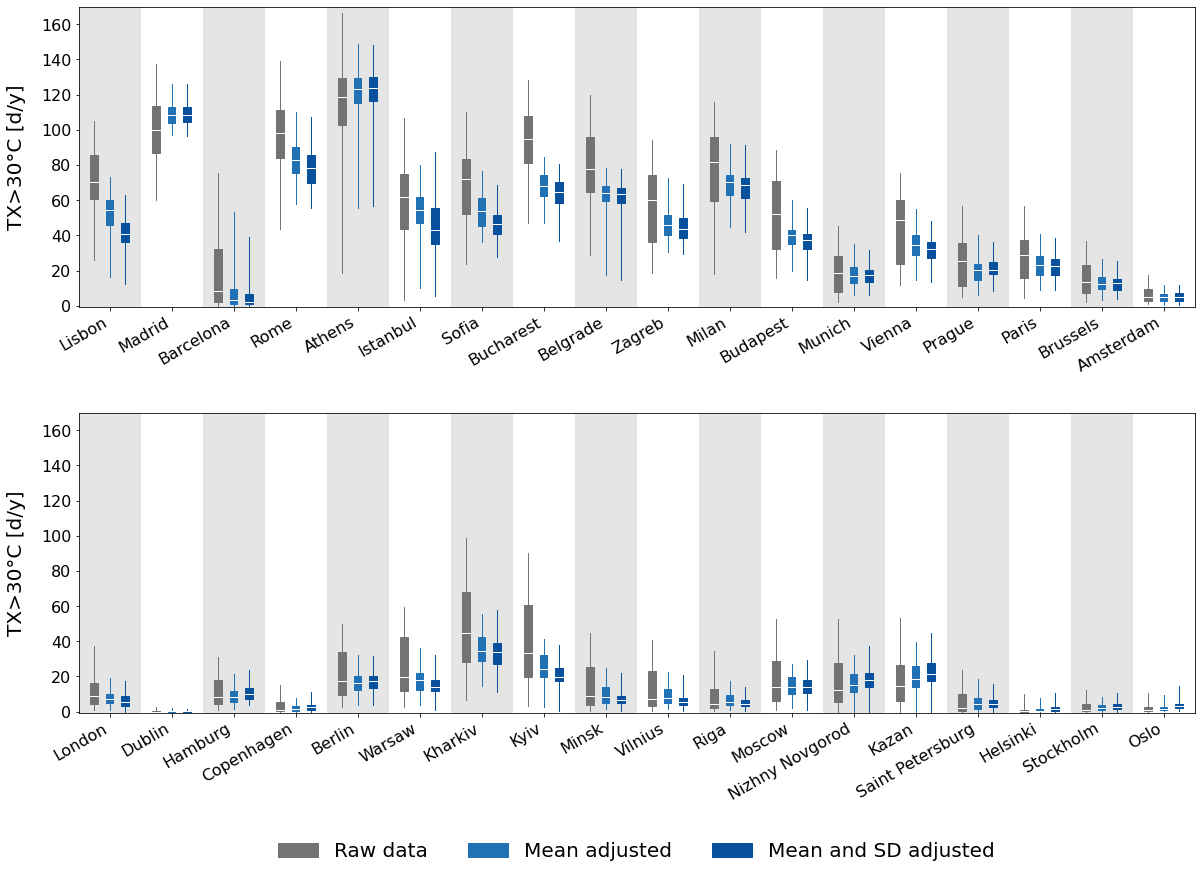

In [7]:
#Define HSI
HSI = 'TX'

out_name = ''

#Read data for threshold exceedance
data_ThrExc = xr.open_dataset(dir_data_ThrExc + 'HSIs-ThresholdExceedance_rcp85_EMT.nc')
data_ThrExc = data_ThrExc.sel(city=cities, EMT_change=EMT_change)

#Split cities into two
N_2 = int(np.ceil(len(cities)/2))
cities_split = []
cities_split.append(cities[0:N_2])
cities_split.append(cities[N_2::])

#Create figure
fig, axes = plt.subplots(2, 1, figsize=(20, 13))
plt.subplots_adjust(hspace=0.35)
p_all = []

sign_coll = pd.DataFrame(0, index=transformations[1::], columns=['higher', 'lower'])


#Loop over city split
for i1, cities_sel in enumerate(cities_split):
    
    ax = axes[i1]

    #Define output names
    cities_out = ['Nizhny Novgorod' if city=='NizhnyNovgorod' else
                  'Saint Petersburg' if city=='SaintPetersburg' else city for city in cities_sel]
    
    #Loop over cities
    for i3, city in enumerate(cities_sel):
        
        #Loop over transformations
        for i2, transformation in enumerate(transformations):
        
            #Extractdata
            data_plot = data_ThrExc.sel(transformation=transformation)
            THR_level = 'Level' + str(THR_levels[HSI])
            val = data_plot.sel(THR_level=THR_level, city=city)[HSI]

            #Plot
            bp = ax.boxplot(val, whis=[0, 100], sym='', positions=[(N+1)*i3 + i2],
                            capprops=dict(color='none'), widths=0.5, patch_artist=True, manage_ticks=False)


            if transformation!='no_trans':
                
                val_orig = data_ThrExc.sel(transformation='no_trans', THR_level=THR_level, city=city)[HSI]
        
                ks_test = scipy.stats.ks_2samp(val.values, val_orig.values).pvalue
                
                median_test = scipy.stats.median_test(val.values, val_orig.values)[1]
            
                if median_test<0.05:
                    if np.median(val)> np.median(val_orig):
                        sign_coll.loc[transformation, 'higher'] = sign_coll.loc[transformation, 'higher'] + 1
                    else:
                        sign_coll.loc[transformation, 'lower'] = sign_coll.loc[transformation, 'lower'] + 1
            
            #Color boxes
            color_boxes(bp, colors[i2])            

            #Make medians white
            for median in bp['medians']:
                median.set(color='w')

            #Collect plot handles for legend
            if i3==0 and i1==0:
                p_all.append(bp["boxes"][0])

        #Set background color
        if np.mod(i3,2)==0:
            ax.axvspan((N+1)*i3 - 1, (N+1)*i3 + (N+1) - 1, facecolor='black', alpha=0.1)

    #Set ticks, limits and labels
    xticks = np.arange((N-1)/2, len(cities_out) * (N + 1), N + 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(cities_out, rotation=30, ha='right', fontsize=16)
    ax.set_xlim([-1, (N + 1) * N_2 - 1])
    ax.set_ylim(lims[HSI])
    ax.set_ylabel('N$_{exc}$ of ' + HSI_out[HSI] + ' [d/y]', fontsize=20, labelpad=15)
    ax.set_ylabel(HSI_out[HSI] + '>' + THR_levels_vals[HSI + '_' + THR_level] + '°C [d/y]', fontsize=20, labelpad=15)
    ax.tick_params(axis = "y", labelsize=16)

#Legend
ax.legend(p_all, [titles[t] for t in transformations], frameon=False, fontsize=20, ncol=len(transformations),
                   loc='lower center', bbox_to_anchor=(0.5, -0.55))

#Save figure
fig_name = 'FigS6_'
plt.savefig(dir_fig + fig_name + 'Boxplots_ThrExc-ztrans_' + HSI + '_dEMT' + EMT_change + out_name + '.png',
            bbox_inches='tight', dpi=300)
